## #3.1. Process lab values in proximity to Mannequin

In [1]:
import pandas as pd
import sys
sys.path.append(r'../src/1_emr_scripts')
import importlib as imp
import LabFunctions as func
import numpy as np

df_lab = pd.read_csv(r'../new_data/2_preprocessing/DF_Lab_firstCon2.csv', sep='|', index_col=0) 

df_lab['uitslag_value'] = df_lab.apply(lambda x: func.use_max_lab(x, col_test='BSE'), axis=1)
df_lab['uitslag_value'] = df_lab.apply(lambda x: func.use_max_lab(x, col_test=['C-Reactief Proteine', 'C-Reaktief Proteine']), axis=1)
# Nr of patients: 1097 	Nr of PseudoIds: 1119
print('Nr of patients:', len(df_lab['patient_id'].unique()), '\tNr of PseudoIds:', len(df_lab['pseudoId'].unique()))

Nr of patients: 1665 	Nr of PseudoIds: 2029


#### Standardize uitslag unit

In [2]:
df_lab['uitslag_unit'] = df_lab['uitslag_unit'].fillna('')
df_lab['uitslag_unit'] = df_lab['uitslag_unit'].replace('10*9/L', 'x10^9/L') # 10*6/L
df_lab['uitslag_unit'] = df_lab['uitslag_unit'].replace('10*6/L', 'x10^6/L')
df_lab['uitslag_unit'] = df_lab['uitslag_unit'].replace('mm/h', 'mm') 
df_lab['uitslag_unit'] = df_lab['uitslag_unit'].replace('', np.nan)

#### Count completeness of different variables

In [3]:
print(len(df_lab[df_lab['test_naam_omschrijving'].isin(['ANF', 'Anti nucleaire antistoffen (ANA)'])]['patient_id'].unique()),
len(df_lab[df_lab['test_naam_omschrijving'].isin(['Anti-CCP', 'Anti-CCP Kwant.'])]['patient_id'].unique()),
len(df_lab[df_lab['test_naam_omschrijving'].isin(['IgM reumafactor', 'RF.M Elisa'])]['patient_id'].unique()),
len(df_lab[df_lab['test_naam_omschrijving'].isin(['Anti-SS-A', 'Anti-SS-A Kwant.'])]['patient_id'].unique()),
     len(df_lab['pseudoId'].unique()))

0 1588 1571 0 2029


### #3.1.1 Cast to wide format

In [5]:
imp.reload(func)

# Exclude mono/lympho / crp
l_remove = ['C-Reactief Proteine', 'Monocyten', 'Lymfocyten']
df_lab = df_lab[~df_lab['test_naam_omschrijving'].isin(l_remove)].copy()

df_lab['Monster_Afname_Datumtijd'] = pd.to_datetime(df_lab['Monster_Afname_Datumtijd'], format='%Y-%m-%d')
df_lab = df_lab.sort_values(by='Monster_Afname_Datumtijd', ascending=False)
l_pat = df_lab['pseudoId'].unique()
df_new = func.reformat_lab(df_lab[df_lab['pseudoId'].isin(l_pat)])
df_new['time'] =  pd.to_datetime(df_new['time'], format='%Y-%m-%d')


Processing lab data...
Progress: row 0 / 38117 (0.0%)
{'BSE (mm)': Timestamp('2018-08-06 17:01:00'), 'Hematocriet (L/L)': Timestamp('2018-08-06 17:01:00'), 'Hemoglobine (mmol/L)': Timestamp('2018-08-06 17:01:00'), 'Trombocyten (10^9/L)': Timestamp('2018-08-06 17:01:00'), 'MCHC (mmol/L)': Timestamp('2018-08-06 17:01:00'), 'MCH (fmol)': Timestamp('2018-08-06 17:01:00'), 'Leukocyten (10^9/L)': Timestamp('2018-08-06 17:01:00'), 'MCV (fl)': Timestamp('2018-08-06 17:01:00'), 'Anti-CCP (U/mL)': Timestamp('2018-08-24 15:54:00'), 'IgM reumafactor (IU/mL)': Timestamp('2018-08-24 15:54:00')}
Progress: row 4765 / 38117 (12.5%)
Progress: row 9530 / 38117 (25.0%)
Progress: row 14295 / 38117 (37.5%)
Progress: row 19060 / 38117 (50.0%)
Progress: row 23825 / 38117 (62.5%)
Progress: row 28590 / 38117 (75.0%)
Progress: row 33355 / 38117 (87.5%)


### #3.1.2 Merge exact duplicates

In [6]:
df_new['patnr'] = df_new['pseudoId'].str[:9] 
df_new = df_new.groupby(['patnr', 'time']).min().reset_index()

### #3.1.3 Infer concentration Lymphocytes & Monocytes
- Use the concentration of the leukocytes to infer the concentration of lymphocytes and monocytes

In [6]:
#df_new['Monocyten'] = df_new['Monocyten (10^9/L)'].fillna((df_new['Monocyten (%)']/100) * df_new['Leukocyten (10^9/L)'])
#df_new['Lymfocyten'] = df_new['Lymfocyten (10^9/L)'].fillna((df_new['Lymfocyten (%)']/100) * df_new['Leukocyten (10^9/L)'])

## #3.2 Extract hidden data from uitslag_text 
- sometimes there is no value registered, but rather a formatted string. In this case we find the value in uitslag_text.

In [10]:
import importlib as imp
imp.reload(func)

l_keep = ['pseudoId', 'time', 'MCV (fl)', 'Hematocriet (L/L)', 'Leukocyten (10^9/L)',
       'MCHC (mmol/L)', 'MCH (fmol)', 'BSE (mm)', 'Hemoglobine (mmol/L)',
       'Trombocyten (10^9/L)', 'Anti-CCP',
       'IgM reumafactor'] # , 'Lymfocyten', 'Monocyten'

d_acpa =  func.create_dict_pat(df_lab, ['Anti-CCP', 'Anti-CCP Kwant.'])
d_rf =  func.create_dict_pat(df_lab, ['IgM reumafactor', 'RF.M Elisa'])

df_new['Anti-CCP'] = df_new['pseudoId'].map(d_acpa).fillna(df_new['Anti-CCP (U/mL)']) # .replace(d_acpa) #.map(d_acpa)
df_new['IgM reumafactor'] = df_new['pseudoId'].map(d_rf).fillna(df_new['IgM reumafactor (IU/mL)']) #.replace(d_rf) #.map(d_rf)

# Export autoantibody tithers
df_new[['pseudoId', 'Anti-CCP (U/mL)', 'IgM reumafactor (IU/mL)']].to_csv('../new_data/9_enrichment/Autoantibody_tithers.csv', index=False)

## #3.3 Standardize to Boolean

In [8]:
import LabFunctions as func
imp.reload(func)


df_new['Anti-CCP'] = df_new['Anti-CCP'].apply(lambda x : func.infer_aCCP(x))
df_new['IgM reumafactor'] = df_new['IgM reumafactor'].apply(lambda x : func.infer_RF(x))
#df_new['Anti-SS-A'] = df_new['Anti-SS-A'].apply(lambda x : func.infer_SSA(x))
#df_new['Anti-ENA'] = df_new['Anti-ENA'].apply(lambda x : func.infer_AntiENA(x))

In [9]:
df_new['Anti-CCP'].unique()

array(['Negatief', 'Positief', nan], dtype=object)

## #3.4 Drop duplicates - keep patients with complete lab profiles

In [10]:
import numpy as np
l_keep = ['pseudoId', 'time', 'MCV (fl)', 'Hematocriet (L/L)', 'Leukocyten (10^9/L)',
       'MCHC (mmol/L)', 'MCH (fmol)', 'BSE (mm)', 'Hemoglobine (mmol/L)',
       'Trombocyten (10^9/L)', 'Anti-CCP',
       'IgM reumafactor'] #, 'Lymfocyten', 'Monocyten'

# Create mannequin dataframe
df_new_lab = pd.DataFrame()

def NearConsult_LookBehind(items, pivot, tol=1):
    """
    Near consult with complete profile 
    """
    items = [item for item in items if (pd.to_datetime(item, format='%Y-%m-%d', errors='ignore') + pd.DateOffset(months=1) >= pd.to_datetime(pivot, format='%Y-%m-%d', errors='ignore')) ]

    if items == []:
        return False
    else : 
        print(items[0], pivot)
        return True
    
def is_incomplete(row, l_keep):
    if any([i != i for i in row[l_keep].values]):
        return True # incomplete lab profile
    else : 
        return False # complete lab profile


df_new['is_incomplete'] = df_new.apply(lambda x : is_incomplete(x, l_keep), axis=1)

df_new['patnr'] = df_new['pseudoId'].str[:-2]#.astype(int)

c_dropped = 0
l_duplicates = [] 
l_dropped_patients =[]

# Loop through all entries
for pid in df_new['pseudoId'].unique():
    if pid in l_duplicates: 
        continue # Skip entries of patients that you may have already processed in a previous step to speed up the algorithm
    
    pat = pid[:-2]
    sub_df = df_new[df_new['patnr']==pat].copy()
    date = sub_df[sub_df['pseudoId']==pid]['time'].iloc[0]
    
    # Get all consult dates with 1month tolerance
    sub_df = sub_df.sort_values(by=['time'])
    items = [item for item in sub_df['time'] if ((pd.to_datetime(item, format='%Y-%m-%d', errors='ignore') + pd.DateOffset(months=1) >= pd.to_datetime(date, format='%Y-%m-%d', errors='ignore')) and (pd.to_datetime(item, format='%Y-%m-%d', errors='ignore') - pd.DateOffset(months=1) <= pd.to_datetime(date, format='%Y-%m-%d', errors='ignore'))) ]
    
    if len(items) > 1:
        l_duplicates.extend(list(set([sub_df[sub_df['time']==time]['pseudoId'].iloc[0] for time in items])))
        
        # For each date of entry (consult date) we collect the lab instances in close proximity. 
        # These are within 1 month of each other and thus often similar due to the small time window
        print(pat, '\tLab instances found (+/- 1 mo from consults):', [time for time in items])
        if len([time for time in items if sub_df[sub_df['time']==time]['is_incomplete'].iloc[0]==False]) > 0:
            l_drop = [time for time in items if sub_df[sub_df['time']==time]['is_incomplete'].iloc[0]==False]
            selected_time = l_drop[0] # select on complete then on first date
            c_dropped += len(l_drop)-1
            l_dropped_patients.extend(l_drop[1:])
        else : 
            selected_time = items[0] # select on first date these patients are dropped anyway more downstream
            c_dropped += len(items)-1
            l_dropped_patients.extend(items[1:])
        df_new_lab = df_new_lab.append(sub_df[sub_df['time']==selected_time].iloc[0], ignore_index=True)   
        l_duplicates.extend([time for time in sub_df[sub_df['time']==selected_time]['pseudoId']])
    else :
        df_new_lab = df_new_lab.append(sub_df[sub_df['pseudoId']==pid], ignore_index=True)

304839982 	Lab instances found (+/- 1 mo from consults): [Timestamp('2018-05-22 11:09:00'), Timestamp('2018-06-07 13:09:00')]


## #3.5 Exclude patients that already use medication or that are missing Rx
- Also exclude patients that have already started treatment (we look 6 months prior to 'supposed' baseline for any drugs)

In [11]:
df_treat = pd.read_csv('../filters/RA_patients_AllNP_inclTreatmentStart.csv', sep='|')
l_missingRx = df_treat[df_treat['FILTER_RX_NA_BASELINE']==True]['pseudoId'].unique()
df_new_lab = df_new_lab[~df_new_lab['pseudoId'].isin(l_missingRx)]

## #3.6 Drop missingness Lab data

In [12]:
df_new = df_new_lab.copy()
len(df_new), len(df_new['patnr'].unique())

(1615, 1552)

In [13]:
df_new = df_new_lab.copy()

# Save all patients
df_new[l_keep].to_csv(r'../new_data/3_wide/DF_Lab_wide_Final.csv', sep='|', index=False)

# Save patients with considerable amount of lab data
df_new[l_keep].dropna().to_csv(r'../new_data/3_wide/DF_Lab_wide_Final2.csv', sep='|', index=False)


### #3.6.1 Elucidate missingness

In [14]:
df_new_lab[l_keep].isnull().sum()/len(df_new_lab[l_keep])*100

pseudoId                0.000000
time                    0.000000
MCV (fl)                6.130031
Hematocriet (L/L)       6.130031
Leukocyten (10^9/L)     6.006192
MCHC (mmol/L)           6.501548
MCH (fmol)              6.130031
BSE (mm)                7.554180
Hemoglobine (mmol/L)    6.130031
Trombocyten (10^9/L)    6.563467
Anti-CCP                4.891641
IgM reumafactor         5.758514
dtype: float64

<AxesSubplot:>

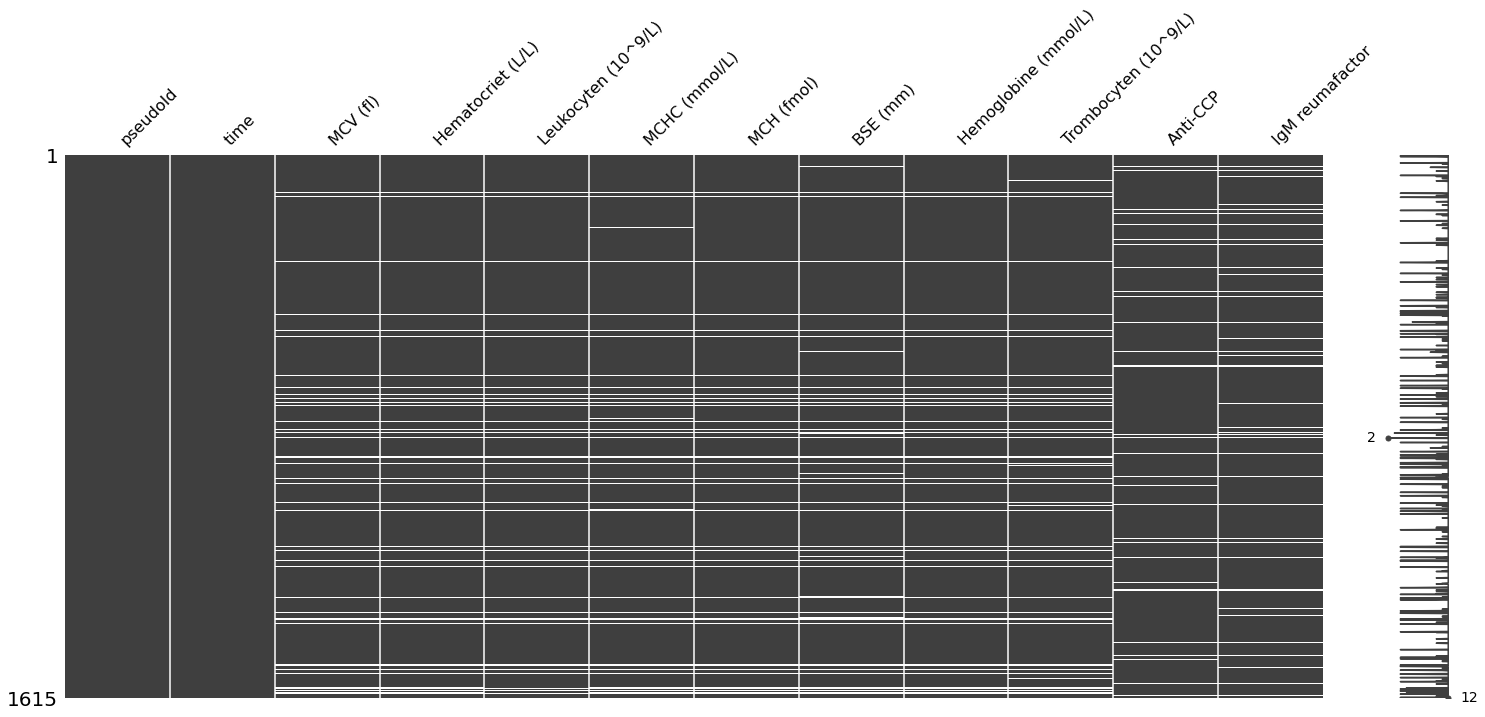

In [15]:
import missingno as msno
    
%matplotlib inline

# df_new[((~df_new['Anti-CCP'].isna()) & (~df_new['IgM reumafactor'].isna()))][l_keep].dropna(thresh=7)
msno.matrix(df_new[l_keep]) # check if patients that miss variables across lines -> have aCCP / RF of 2

## #3.7 Process alternative Lab values (around first appointment)
#### Dropped patients
Some patients do not have a Mannequin, in this case we look from the baseline to elucidate the lab profile of the patients that will be dropped

In [16]:
print('yee')
import pandas as pd
import sys
sys.path.append(r'../src/1_emr_scripts')
import importlib as imp
import LabFunctions as func
print('C H E C K P O I N T')

l_keep = ['pseudoId', 'time', 'MCV (fl)', 'Hematocriet (L/L)', 'Leukocyten (10^9/L)',
       'MCHC (mmol/L)', 'MCH (fmol)', 'BSE (mm)', 'Hemoglobine (mmol/L)',
       'Trombocyten (10^9/L)', 'Anti-CCP',
       'IgM reumafactor'] # , 'Lymfocyten', 'Monocyten'

df_lab = pd.read_csv(r'../new_data/2_preprocessing/DF_Lab_firstCon_PEC.csv', sep='|', index_col=0) 

df_lab['uitslag_value'] = df_lab.apply(lambda x: func.use_max_lab(x, col_test='BSE'), axis=1)
df_lab['uitslag_value'] = df_lab.apply(lambda x: func.use_max_lab(x, col_test=['C-Reactief Proteine', 'C-Reaktief Proteine']), axis=1)

print('Nr of patients:', len(df_lab['patient_id'].unique()), '\tNr of PseudoIds:', len(df_lab['pseudoId'].unique()))

# Cast to wide format
df_lab = df_lab.sort_values(by='FirstConsult', ascending=False)
l_pat = df_lab['pseudoId'].unique()
df_new = func.reformat_lab(df_lab[df_lab['pseudoId'].isin(l_pat)])

d_acpa =  func.create_dict_pat(df_lab, ['Anti-CCP', 'Anti-CCP Kwant.'])
d_rf =  func.create_dict_pat(df_lab, ['IgM reumafactor', 'RF.M Elisa'])

df_new['Anti-CCP'] = df_new['pseudoId'].map(d_acpa).fillna(df_new['Anti-CCP (U/mL)']) # .replace(d_acpa) #.map(d_acpa)
df_new['IgM reumafactor'] = df_new['pseudoId'].map(d_rf).fillna(df_new['IgM reumafactor (IU/mL)']) #.replace(d_rf) #.map(d_rf)


# Replace extreme Outliers in Leukocytes with NA
df_new['Leukocyten (10^9/L)'] = df_new['Leukocyten (10^9/L)'].apply(lambda x : np.nan if x > 100 else x) 

# Infer Monocytes and Lymfocytes
df_new['Monocyten'] = df_new['Monocyten (10^9/L)'].fillna((df_new['Monocyten (%)']/100) * df_new['Leukocyten (10^9/L)'])
df_new['Lymfocyten'] = df_new['Lymfocyten (10^9/L)'].fillna((df_new['Lymfocyten (%)']/100) * df_new['Leukocyten (10^9/L)'])

# Infer autoantibodies
df_new['Anti-CCP'] = df_new['Anti-CCP'].apply(lambda x : func.infer_aCCP(x))
df_new['IgM reumafactor'] = df_new['IgM reumafactor'].apply(lambda x : func.infer_RF(x))

# Save all patients
df_new[l_keep].to_csv(r'../new_data/3_wide/DF_Lab_wide_PEC_Final2.csv', sep='|', index=False)

yee
C H E C K P O I N T
Nr of patients: 2069 	Nr of PseudoIds: 2590

Processing lab data...
Progress: row 0 / 52190 (0.0%)
{'Hemoglobine (mmol/L)': '2018-08-02 10:13:00', 'Hematocriet (L/L)': '2018-08-02 10:13:00', 'MCV (fl)': '2018-08-02 10:13:00', 'MCHC (mmol/L)': '2018-08-02 10:13:00', 'BSE (mm/h)': '2018-08-02 10:13:00', 'Trombocyten (10*9/L)': '2018-08-02 10:13:00', 'MCH (fmol)': '2018-08-02 10:13:00', 'C-Reactief Proteine (mg/L)': '2018-08-02 10:13:00', 'Leukocyten (10*9/L)': '2018-08-02 10:13:00', 'Lymfocyten (10*9/L)': '2018-08-23 17:00:00', 'Monocyten (10*9/L)': '2018-08-23 17:00:00', 'Anti-CCP (U/mL)': '2018-08-23 17:00:00', 'IgM reumafactor (IU/mL)': '2018-08-23 17:00:00'}
Progress: row 6524 / 52190 (12.5%)
Progress: row 13048 / 52190 (25.0%)
Progress: row 19572 / 52190 (37.5%)
Progress: row 26096 / 52190 (50.0%)
Progress: row 32620 / 52190 (62.5%)
Progress: row 39144 / 52190 (75.0%)
Progress: row 45668 / 52190 (87.5%)


## #3.8 Normalize lab data
Apply Z-scale normalization (Important to do this before Imputation)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # Z-score
from sklearn.preprocessing import RobustScaler  # Robust Z-score
from sklearn.preprocessing import PowerTransformer # Yeo-Johnson
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

def BinarizeSerology(val, include_na=True):
    """
    Standardize the categorical variables to numerical values
    
    where:
        0 = Negative
        1 = Positive
        2 = Missing
    
    Input:
        val = Categorical value 
        include_na = whether or to include missing values
            - in case the missingness contains information
            - you should keep these values!
    Output:
        val = codified categorical value
    """
    
    if val in ['Positief', 'Sterk pos.', 'Sterk pos', 'Sterk Positief']:
        val = 1
    elif val in ['Dubieus', 'Negatief', 'Zwak pos.', 'Zwak pos', 'Zwak Positief']:
        val= 0
    elif include_na:
        if val in ['Stopgezet', '-volgt-', '@volgt', 'Niet doorgeg', 'Niet het jui', 
                   'gestopt', 'Bepaling niet ui', ' ', 'Geen analyse mog', 'Te weinig materi', 
                   'Geen materiaal o', 'te weinig ma', 'gestopt',  'Geen analyse', 'geen uitslag', np.nan]:
            val = np.nan
    return val

def normalizeLab(df):
    """
    Input: 
        df = complete dataframe
    
    Description:
        This function processes the Lab data. 
        Categorical data is subjected to a one-hot-encoding
        while the numerical data is cast to a z-scale as normalization
        
        Furthermore, the ESR (or BSE in dutch) is subjected to a 
        log-transformation.
    
    Output:
        df_dummies = dataframe with preprocessed categorical data 
        df_b = dataframe with preprocessed numerical data
    """
    l_num = ['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC', 'MCV', 'Trom',  'BSE'] # 'Lym', 'Mono', 
    l_cat = ['RF', 'aCCP']
    
    # Log transform the ESR data
    df['BSE'] = np.log(df['BSE'])
    # 
    # np.log(df['BSE'])
    
    ct = ColumnTransformer([("num", PowerTransformer(), l_num)], remainder="passthrough")
    df_num= pd.DataFrame(ct.fit_transform(df[l_num]), columns=l_num)
    df_cat = df[l_cat].copy()
    
    def cast_to_one_hot(values):
        # integer encode

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
        
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        if len(np.unique(values)) == 3:
            df = pd.DataFrame(onehot_encoded, columns=[0, 1,2])
            df.index = np.arange(0, len(df))  
            return df[0], df[1], df[2] 
        elif len(np.unique(values)) == 2:
            df = pd.DataFrame(onehot_encoded, columns=[0, 1])
            df.index = np.arange(0, len(df))  
            return df[0], df[1], None  
        elif len(np.unique(values)) < 2:
            return None, None, None  

    def cast_to_str(x):
        d = {1: 'positive', 0:'negative', 2: 'missing'}
        return d[x]

    CATEGORICAL_PROCESSING = False
    # Categorical preprocessing
    if CATEGORICAL_PROCESSING:
    
        for cat in l_cat:
            print(cat)
            print(df_cat[cat].unique())
            # This will give an error if your index doesnt count from 0 to n
            df_cat['%s_negative' % (cat)], df_cat['%s_positive' % (cat)], df_cat['%s_missing' % (cat)] = cast_to_one_hot(df_cat[cat].values)
            #print(matrix[cat + '_negative' ])
            if len(df_cat[df_cat[cat + '_negative' ].isna()])>1: # remove if column doesnt hold any information:
                df_cat = df_cat.drop(columns=['%s_negative' % (cat), '%s_positive' % (cat), '%s_missing' % (cat)])
                print("Column %s doesn't hold any information and is therefore removed" % (cat))
            df_cat = df_cat.drop(columns=cat)
        df_cat = df_cat.dropna(axis=1, how='all')
    df_imp = df_cat.merge(df_num, left_index=True, right_index=True)
    
    df_imp = df_imp.merge(df[['pseudoId', 'time']], left_index=True, right_index=True)
    
    
    return df_imp

l_datasets = ['DF_Lab_wide_Final2.csv', 'DF_Lab_wide_PEC_Final2.csv']
d_name = {'DF_Lab_wide_Final2.csv': 'DF_Lab_wide_scaled.csv', 'DF_Lab_wide_PEC_Final2.csv': 'DF_Lab_wide_PEC_scaled.csv'}
d_name_raw = {'DF_Lab_wide_Final2.csv': 'DF_Lab_wide_unscaled.csv', 'DF_Lab_wide_PEC_Final2.csv': 'DF_Lab_wide_PEC_unscaled.csv'}

# Alternate between the two datasets to scale / ohe the data
for dataset in l_datasets:
    # Import Lab values
    df_lab = pd.read_csv(r'../new_data/3_wide/%s' % (dataset), sep='|')

    # Abbreviate column names
    new_lab_cols = {'MCV (fl)': "MCV", 'Hematocriet (L/L)' : "Ht",'Leukocyten (10^9/L)' : "Leuko", 'MCHC (mmol/L)' : "MCHC", 'MCH (fmol)' : "MCH", 'BSE (mm)' : "BSE", 'Hemoglobine (mmol/L)' : "Hb", 'Trombocyten (10^9/L)' : "Trom", 'Anti-CCP' : "aCCP",'IgM reumafactor' : "RF", "Lymfocyten" : "Lym", "Monocyten" : "Mono"}
    # , 'Lymfocyten' : "Lym", 'Monocyten' : "Mono"
    df_lab = df_lab.rename(columns=new_lab_cols)
    
    # Encode antigen test labels
    l_cat = ['RF', 'aCCP'] 
    for cat in l_cat:
        df_lab[cat] = df_lab[cat].apply(lambda x : BinarizeSerology(x, include_na=True))
        
    # Save lab data (unnormalized)
    df_lab.to_csv(r'../new_data/3_wide/%s' % (d_name_raw[dataset]), sep='|', index=False)
    
    print('Written to ../new_data/3_wide/%s' % (d_name_raw[dataset]))
    
    # Normalize lab values
    df_lab = normalizeLab(df_lab)

    # Save lab data (normalized)
    df_lab.to_csv(r'../new_data/4_processed/%s' % (d_name[dataset]), sep='|', index=False)

Written to ../new_data/3_wide/DF_Lab_wide_unscaled.csv
Written to ../new_data/3_wide/DF_Lab_wide_PEC_unscaled.csv


## #3.9 Add LAB data to patient characteristics

- Use Lab data close to mannequin or use lab data around PEC when there is no mannequin (or no data found in proximity to the mannequin). 

In [18]:
import pandas as pd

l_keep = ['pseudoId', 'time', 'RF', 'aCCP', 'Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',
        'MCV', 'Trom',  'BSE'] # 'Lym', 'Mono',

#new_lab_cols = {'MCV (fl)': "MCV", 'Hematocriet (L/L)' : "Ht",'Leukocyten (10^9/L)' : "Leuko", 'MCHC (mmol/L)' : "MCHC", 'MCH (fmol)' : "MCH", 'BSE (mm)' : "BSE", 'Hemoglobine (mmol/L)' : "Hb", 'Trombocyten (10^9/L)' : "Trom", 'Anti-CCP' : "aCCP",'IgM reumafactor' : "RF", 'Lymfocyten' : "Lym", 'Monocyten' : "Mono"}

# Import all patient information
df_treat = pd.read_csv(r'../filters/RA_patients_AllNP_inclTreatment+Mannequin.csv', sep='|', index_col=0)

# use  lab values in proximity to as base table
df_lab_pec = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_PEC_unscaled.csv', sep='|') 
df_treat_new = df_treat.merge(df_lab_pec[l_keep], on='pseudoId', how='outer')
print("positive control (should be 0): ", len(set(df_treat['pseudoId']) - set(df_treat_new['pseudoId']))) # positive control: should be 0

# Update if LAB near Mannequin is found
df_lab = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_unscaled.csv', sep='|')

# Replace values in base table with the lab values that we found in proximity to0 the mannequin!
df_treat_new[l_keep] = df_treat_new['pseudoId'].apply(lambda x: df_lab[df_lab['pseudoId']==x][l_keep].iloc[0] if x in df_lab['pseudoId'].unique() else df_treat_new[df_treat_new['pseudoId']==x][l_keep].iloc[0])

# add two columns to show missingness
print("positive control (should be 0): ", len(set(df_treat['pseudoId']) - set(df_treat_new['pseudoId']))) # positive control: should be 0
#print(len(df_treat_new[(df_treat_new['aCCP_missing']!=1) & (df_treat_new['aCCP_missing']!=1)][l_keep].dropna(thresh=7)))


positive control (should be 0):  0
positive control (should be 0):  0


#### Also merge unscaled data

In [19]:
import pandas as pd

l_keep = ['pseudoId', 'time', 'RF', 'aCCP', 'Leuko', 'MCH', 'Hb', 'Ht', 'MCHC',
       'MCV', 'Trom',  'BSE'] # 'Lym', 'Mono', 

# Import all patient information
df_treat = pd.read_csv(r'../filters/RA_patients_AllNP_inclTreatment+Mannequin.csv', sep='|', index_col=0)

# use  lab values in proximity to as base table
df_lab_pec = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_PEC_unscaled.csv', sep='|') 
df_treat_new = df_treat.merge(df_lab_pec[l_keep], on='pseudoId', how='outer')
print("positive control (should be 0): ", len(set(df_treat['pseudoId']) - set(df_treat_new['pseudoId']))) # positive control: should be 0

# Update if LAB near Mannequin is found
df_lab = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_unscaled.csv', sep='|')

# Replace values in base table with the lab values that we found in proximity to the mannequin!
df_treat_new[l_keep] = df_treat_new['pseudoId'].apply(lambda x: df_lab[df_lab['pseudoId']==x][l_keep].iloc[0] if x in df_lab['pseudoId'].unique() else df_treat_new[df_treat_new['pseudoId']==x][l_keep].iloc[0])
df_treat_new[l_keep].to_csv(r'../new_data/4_processed/DF_Lab_unscaled.csv', sep='|', index=False)

# add two columns to show missingness
print("positive control (should be 0): ", len(set(df_treat['pseudoId']) - set(df_treat_new['pseudoId']))) # positive control: should be 0
#print(len(df_treat_new[(df_treat_new['aCCP_missing']!=1) & (df_treat_new['aCCP_missing']!=1)][l_keep].dropna(thresh=7)))


positive control (should be 0):  0
positive control (should be 0):  0


### #3.9.1 add age and sex

In [ ]:
from datetime import datetime, date
import numpy as np

def age(row): 
    """
    Calculate the age of the patient
    
    Input:
        row = entry of patient
    Output:
        age = age of paitient
    """
    born = row['birthDate']
    pec = row['FirstConsult']
    if type(pec) != float and type(born) != float:
        pec = datetime.strptime(pec[:10], "%Y-%m-%d").date()
        born = datetime.strptime(born[:19], "%Y-%m-%d %H:%M:%S").date()
        return pec.year - born.year - ((pec.month, 
                                          pec.day) < (born.month, 
                                                        born.day))
    else :
        return np.nan
    
def binarize_sex(sex):
    """
    Cast string type values to binary (male= 0, female=1)
    """
    if sex == 'M':
        return 0
    else :
        return 1

df_ageSex = pd.read_csv(r'../new_data/1_raw/Demographics_REU.csv', sep=';')

df_ageSex['Sex'] = df_ageSex['gender_code_original'].apply(lambda x: binarize_sex(x))

df_ageSex = df_ageSex.rename(columns={"identifier_value": "patnr"})

# add age & sex to lab values
df_treat_new = df_treat_new.merge(df_ageSex[['birthDate', 'Sex', 'patnr']], on='patnr', how='outer')

# calculate age from day of birth
df_treat_new['Age'] = df_treat_new.apply(lambda x: age(x), axis= 1)

#df_treat_new.head()

### #3.9.2 Add ESR to gewrichtspop data to prepare DAS calculation

In [21]:
import pandas as pd

# Import Mannequin data
new_df = pd.read_csv(r'../new_data/1_raw/Clustering_Gewrichtspop.csv', sep='|')
l_components = ['Scorelijsten', 'Pijn', 'Zwelling', 'Totaal gezwollen gewrichten', 'Totaal pijnlijke gewrichten', 'Gezwollen gewrichten', 'Pijnlijke gewrichten', 'Protheses arthrodeses', 'Gewrichten met prothese', 'DAS 44', 'DAS 44(3)', 'Pijn (VAS) *', 'Pijn (VAS)', 'VAS arts (mm)', 'VAS Patient (mm)', 'VAS score', 'Pijn (VAS in cm): 0 (geen) - 10 (ondraaglijk)', 'Pijnscore VAS', 'VAS Algemeen welbevinden laatste week (schaal 0-10; +/- 0.5)', 'VAS Pijn laatste week (schaal 0-10; +/- 0.5)', 'BSE', 'Geen gezwollen gewrichten', 'Gewrichten met arthrodese' , 'Geen protheses arthrodeses', 'Geen pijnlijke gewrichten', 'DAS 28(3)', 'DAS 28', 'DAS 44 totaal pijn', 'DAS 44 rechts pijn', 'DAS 44 links pijn', 'DAS 44 totaal zwelling', 'DAS 44 links zwelling', 'DAS 44 rechts zwelling', 'DAS 28 rechts pijn', 'DAS 28 totaal pijn', 'DAS 28 links pijn', 'DAS 28 totaal zwelling', 'DAS 28 links zwelling', 'DAS 28 rechts zwelling', 'Afspraak vervolgconsult', 'Datum eerste consult', 'Reuma noduli aanwezig']

new_df.columns = ['ID', 'STELLING', 'ANTWOORD', 'YANTWOORD', 'ZANTWOORD', 'PATNR', 'XANTWOORD', 'DATUM', 'Cs-code', 'CATEGORIE',  'BEHANDELAAR', 'DATUM_A', 'MUTDAT']

# Import Sedimentation rate (to calculate DAS28 score)
bse_df = pd.read_csv(r'../new_data/1_raw/Lab_REU.csv', sep=';')

# change column names
bse_df = bse_df[['effectiveDateTime', 'code_display_original', 'valueQuantity_value', 'valueQuantity_code_original', 'subject_Patient_value', 'valueString', 'issued_date']]
bse_df.columns = ['Monster_Afname_Datumtijd', 'test_naam_omschrijving', 'uitslag_value', 'uitslag_unit', 'patient_id', 'uitslag_text', 'issued_date']
bse_df['Monster_Afname_Datumtijd'] = pd.to_datetime(bse_df['Monster_Afname_Datumtijd'], format='%Y-%m-%d', errors='ignore')#.dt.strftime('%d-%m-%Y')

# select relevant column
bse_df =bse_df[bse_df['test_naam_omschrijving']=='BSE']
df_pat = pd.read_csv(r'../filters/RA_patients_AllNP_inclTreatment+Mannequin.csv', sep='|', index_col=0)
new_pat = dict(zip(df_treat['patnr'], df_treat['FirstConsult']))

bse_df= bse_df[bse_df['patient_id'].isin(new_pat.keys())]

# Fill in Max value for ESR if ESR is above threshold
bse_df['uitslag_value'] = bse_df.apply(lambda x : 140 if x['uitslag_text'] == '>140' else x['uitslag_value'], axis=1)
# Standardize unit 
bse_df['uitslag_unit'] = bse_df['uitslag_unit'].replace('mm', 'mm/h')

# Add Sedimentation rate to Mannequin data
bse_df = pd.concat([pd.DataFrame([[i, bse_df['patient_id'].iloc[i], bse_df['Monster_Afname_Datumtijd'].iloc[i], bse_df['Monster_Afname_Datumtijd'].iloc[i], 'BSE', bse_df['uitslag_value'].iloc[i], bse_df['uitslag_value'].iloc[i], bse_df['uitslag_unit'].iloc[i], 'REU']], columns=['ID', 'PATNR', 'DATUM', 'DATUM_A', 'STELLING', 'ANTWOORD', 'XANTWOORD', 'YANTWOORD', 'CATEGORIE']) for i in range(len(bse_df))],
          ignore_index=True)
new_df = pd.concat([new_df[['ID', 'PATNR', 'DATUM', 'DATUM_A', 'STELLING', 'ANTWOORD', 'XANTWOORD', 'YANTWOORD', 'CATEGORIE']], bse_df])
new_df = new_df.reset_index(drop=True)
new_df.to_csv(r'../new_data/1_raw/Clustering_Gewrichtspop_with_BSE.csv', sep='|', index=False)

### #3.9.3 Perform DAS calculation

Run offshoots/Compute_DAS.ipynb

### #3.9.4 Add Filters & calculate days till treatment

In [22]:
import numpy as np

# Load DAS & Mannequin data
df_das = pd.read_csv('../new_data/7_final/DAS_patients.csv', sep=';')

# Load function to acquire date of first consult from dictionary
def getPseudoId(row, df):
    pat = row['patnr']
    sub_df = df[(df['patnr']==pat)].copy()
    pseudo_id = sub_df[((pd.to_datetime(row['date'], format='%d-%m-%Y', errors='ignore') > pd.to_datetime(sub_df['FirstConsult'], format='%Y-%m-%d', errors='ignore'))
               & (pd.to_datetime(row['date'], format='%d-%m-%Y', errors='ignore') <  pd.to_datetime(sub_df['Lookahead_Treatment'], format='%Y-%m-%d', errors='ignore')))]['pseudoId']
    
    if len(pseudo_id) > 0:
        return pseudo_id.iloc[0]
    else : 
        return np.nan

def getFirstTREATPEC(pat, df):
    if type(pat) != float :
        return df[df['pseudoId']==pat]['Lookahead_Treatment'].iloc[0]
    else :
        return np.nan

# Add first consult date
df_das['pseudoId'] = df_das.apply(lambda x: getPseudoId(x, df_treat_new), axis=1)

# Add first consult date
df_das['TREATPEC'] = df_das['pseudoId'].apply(lambda x: getFirstTREATPEC(x, df_treat_new))

l_keep = ['FirstDAS', 'DAS28(3)', 'DAS44', 'pseudoId']

df_das = df_das.rename(columns={'date': 'FirstDAS'})
df_das = df_das.sort_values(by='FirstDAS')

print('Nr of patients: ', len(df_treat_new))
df_treat_new = df_treat_new.merge(df_das[l_keep].drop_duplicates('pseudoId'), on='pseudoId', how='left')
print('Nr of patients: ', len(df_treat_new))

# LAB Missing filter
df_lab_all = pd.read_csv(r'../new_data/1_raw/Lab_REU.csv', sep=';') 
l_lab_present = list(df_lab_all['subject_Patient_value'].unique())
df_treat_new['FILTER_LAB_NA'] = df_treat_new['patnr'].apply(lambda x : False if x in l_lab_present else True)

# LAB Missing at baseline
df_lab = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_unscaled.csv', sep='|') 
l_lab_present = list(df_lab['pseudoId'].unique())
df_treat_new['FILTER_LAB_NA_BASELINE'] = df_treat_new['pseudoId'].apply(lambda x : True if x not in l_lab_present else False)

# Remove empty rows
df_treat_new = df_treat_new[~df_treat_new['pseudoId'].isna()]

## Save table with characteristics
df_treat_new.to_csv(r'../filters/RA_patients_AllNP_Characteristics.csv', sep='|', index=False)

Nr of patients:  2695
Nr of patients:  2695


In [23]:
import pandas as pd
# LAB Missing at baseline
df_lab = pd.read_csv(r'../new_data/3_wide/DF_Lab_wide_unscaled.csv', sep='|') 
l_lab_present = list(df_lab['pseudoId'].unique())
df_lab['patnr'] = df_lab['pseudoId'].str[:9]
len(l_lab_present), len(df_lab['patnr'].unique())

(1387, 1343)

## Visualize correlation between lab variables

<ipython-input-25-59d8d889c58e>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_new[[key for key in df_new.columns if key in new_lab_cols.values()]].corr(), dtype=np.bool))


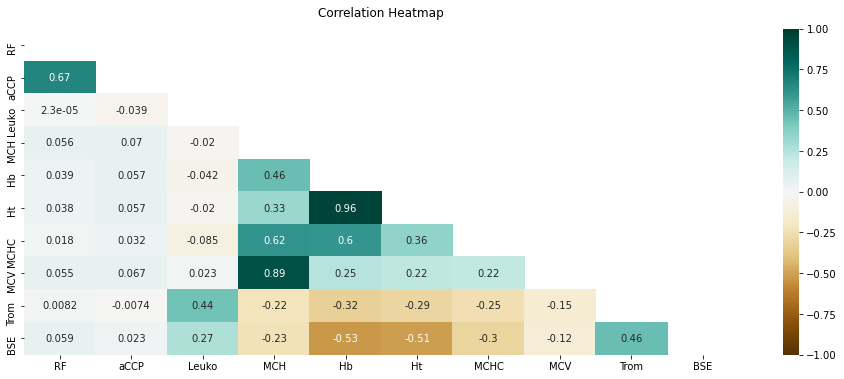

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df_new = pd.read_csv(r'../new_data/4_processed/DF_Lab_wide_scaled.csv', sep='|')
new_lab_cols = {'MCV (fl)': "MCV", 'Hematocriet (L/L)' : "Ht",'Leukocyten (10^9/L)' : "Leuko", 'MCHC (mmol/L)' : "MCHC", 'MCH (fmol)' : "MCH", 'BSE (mm)' : "BSE", 'Hemoglobine (mmol/L)' : "Hb", 'Trombocyten (10^9/L)' : "Trom", 'Anti-CCP' : "aCCP",'IgM reumafactor' : "RF", "Lymfocyten" : "Lym", "Monocyten" : "Mono"}
df_new = df_new.rename(columns=new_lab_cols)
df_new['aCCP']

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_new[[key for key in df_new.columns if key in new_lab_cols.values()]].corr(), dtype=np.bool))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_new[[key for key in df_new.columns if key in new_lab_cols.values()]].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);